In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.dates as mdates
import numpy as np

In [91]:
# Load datasets
order_df =pd.read_csv('/content/drive/MyDrive/Git Hub /product order dump.csv')
order_revenue = pd.read_csv('/content/drive/MyDrive/Git Hub /Orders Revenue Dump.csv')
print(order_df.info())
print(order_revenue.info())
print(order_df.isna().any())
print(order_revenue.isna().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 61 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Product Name  263 non-null    object 
 1   APR 2021      263 non-null    int64  
 2   MAY 2021      263 non-null    int64  
 3   JUN 2021      263 non-null    int64  
 4   JULY 2021     262 non-null    float64
 5   AUG 2021      263 non-null    int64  
 6   SEP 2021      263 non-null    int64  
 7   OCT 2021      263 non-null    int64  
 8   NOV 2021      263 non-null    int64  
 9   DEC 2021      263 non-null    int64  
 10  JAN 2022      263 non-null    int64  
 11  FEB 2022      263 non-null    int64  
 12  MAR 2022      263 non-null    int64  
 13  APR 2022      263 non-null    int64  
 14  MAY 2022      263 non-null    int64  
 15  JUN 2022      263 non-null    int64  
 16  JULY 2022     263 non-null    int64  
 17  AUG 2022      263 non-null    int64  
 18  SEP 2022      263 non-null    

In [92]:
# Set random seed for reproducibility
np.random.seed(42)

# Melt the order data to long format
order_data= order_df.melt(
    id_vars=["Product Name"],
    var_name="Date",
    value_name="Quantity"
)

# Clean up inconsistent month names, here JUL and SEP
order_data['Date'] = order_data['Date'].replace({
    'JULY': 'JUL',
    'SEPT': 'SEP'
}, regex=True)

# Convert date string to datetime format
order_data["Date"] = pd.to_datetime(order_data["Date"], format="%b %Y")

#scale data
order_data['Quantity'] = (
    order_data['Quantity'].fillna(0)
    .apply(lambda x: max(0, round((x + np.random.uniform(-x*0.5, x*1.5)) * np.random.uniform(0.6, 1.5))))
)


# Group data to get monthly total quantity sold
monthly_sales = order_data.groupby('Date')['Quantity'].sum().reset_index()

# Filter out NaN and 0 values
monthly_sales = monthly_sales[monthly_sales['Quantity'].notna()]
monthly_sales = monthly_sales[monthly_sales['Quantity'] != 0]

# Sort and create readable date labels
monthly_sales = monthly_sales.sort_values('Date')
monthly_sales['Month_Year'] = monthly_sales['Date'].dt.strftime('%b %Y')
monthly_sales['Date_Ordinal'] = monthly_sales['Date'].map(pd.Timestamp.toordinal)


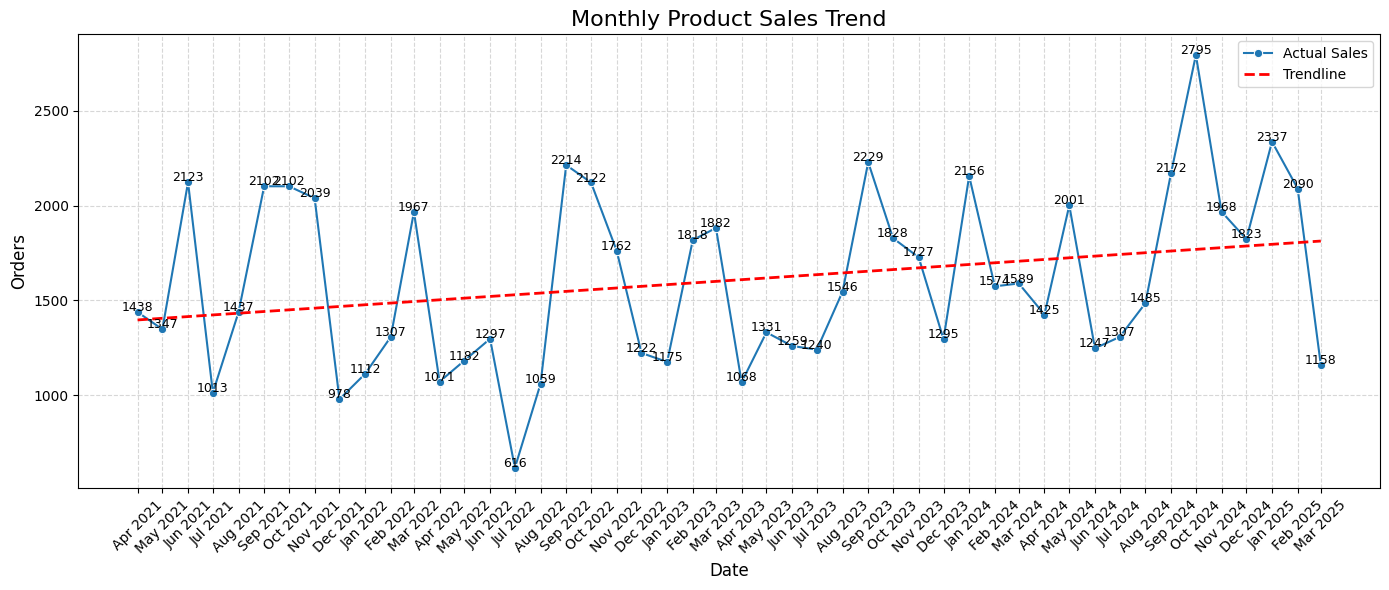

In [93]:
# Line plot with trendline
plt.figure(figsize=(14, 6))
sns.lineplot(x='Date_Ordinal', y='Quantity', data=monthly_sales, marker='o', label='Actual Sales')

sns.regplot(x='Date_Ordinal', y='Quantity', data=monthly_sales,
            scatter=False, color='red', label='Trendline',ci=None,
            line_kws={"linestyle": "dashed", "linewidth": 2})


plt.xticks(
    ticks=monthly_sales['Date_Ordinal'],
    labels=monthly_sales['Month_Year'],
    rotation=45
)

for x, y in zip(monthly_sales['Date_Ordinal'], monthly_sales['Quantity']):
    plt.text(x, y + 5, str(int(y)), ha='center', fontsize=9)


plt.title('Monthly Product Sales Trend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Orders', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()


<ipython-input-94-5f26dafb8246>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales['Date'] = pd.date_range(start="2022-04-01", periods=len(monthly_sales), freq='M')
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


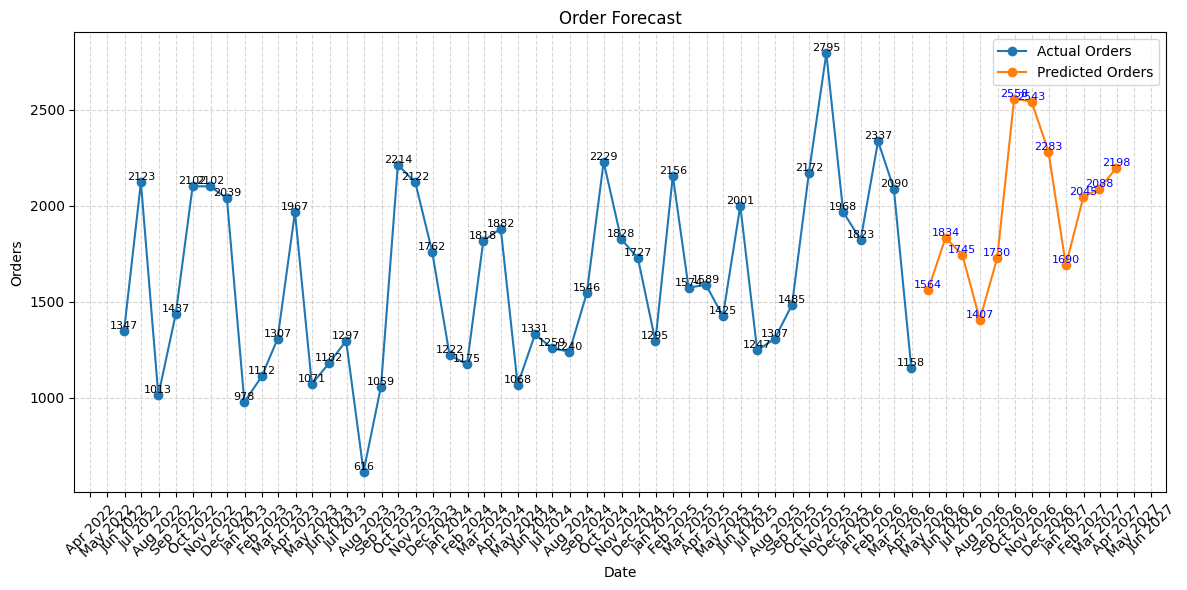

In [94]:
monthly_sales['Date'] = pd.date_range(start="2022-04-01", periods=len(monthly_sales), freq='M')
monthly_sales.set_index('Date', inplace=True)

# Forecast next 12 months using Holt-Winters model
model = ExponentialSmoothing(
    monthly_sales.Quantity,
    seasonal='add',
    seasonal_periods=12,
    trend='add',
    damped_trend=True
)
fit = model.fit()


forecast = fit.forecast(steps=12)


plot_data = monthly_sales[monthly_sales.index >= '2022-05-01']

# Plot actual vs forecasted sales
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(plot_data.index, plot_data.Quantity, label='Actual Orders', marker='o')
ax.plot(forecast.index, forecast, label='Predicted Orders', marker='o')

# Annotate points
for x, y in zip(plot_data.index, plot_data.Quantity):
    ax.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8)

for x, y in zip(forecast.index, forecast):
    ax.text(x, y, f'{y:.0f}', ha='center', va='bottom', fontsize=8, color='blue')


ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Order Forecast')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [95]:
# Prepare revenue data
order_revenue = order_revenue.sort_values(by='Order Date')
order_revenue.Price = order_revenue.Price.replace({'AED': '', ',': ''}, regex=True)
order_revenue.Price = order_revenue.Price.astype(float)

order_revenue['Order Date'] = pd.to_datetime(order_revenue['Order Date'])
order_revenue = order_revenue[order_revenue['Order Date'] >= '2024-04-01']
order_revenue = order_revenue.sort_values(by='Order Date')

# Remove duplicates and summarize revenue per product
modified_data = order_revenue.drop_duplicates(subset='Item Number', keep='first')


product_name = modified_data.groupby(by='Product')['Price'].sum().reset_index()
product_name = product_name.sort_values(by='Price',ascending=False)

revenue_scale = np.random.uniform(0.4, 0.7)
product_name['Price'] *= revenue_scale
product_name['Price'] = product_name['Price'].round(2)

# Calculate revenue contribution
total_revenue = product_name['Price'].sum()

product_name['Revenue_Weight'] = (product_name['Price'] / total_revenue) * 100
product_name['Revenue_Weight'] = product_name['Revenue_Weight'].round(2)



<ipython-input-96-21cf4c8efc8d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_products, x='Revenue_Weight', y='Product', palette='viridis')


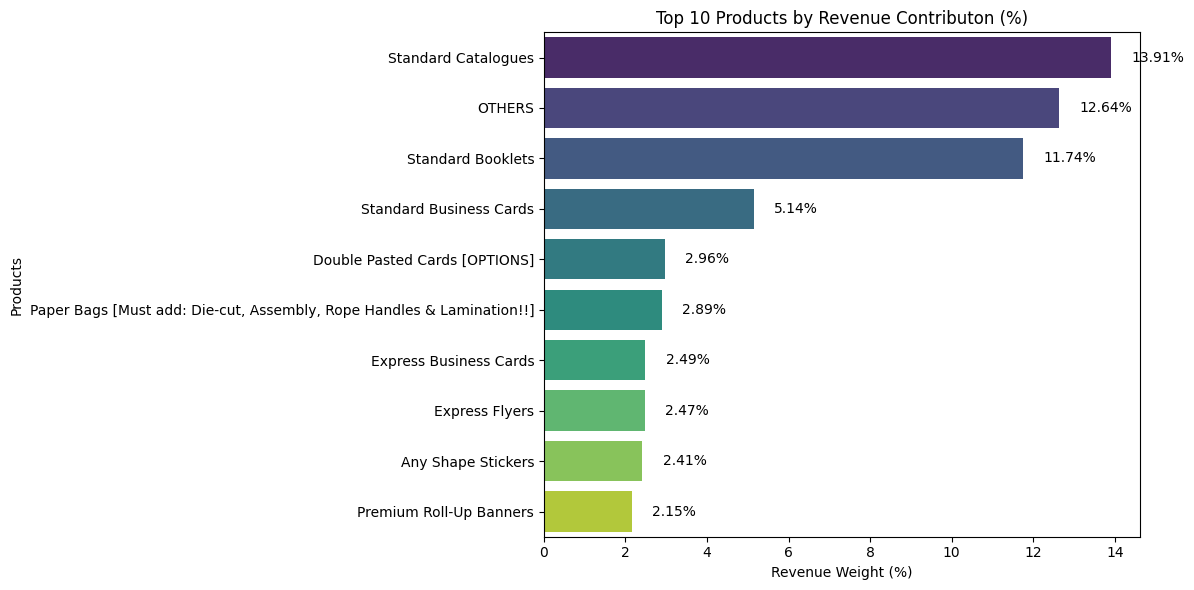

In [96]:
# Plot Top 10 Products by Revenue Contribution
top_10_products = product_name.nlargest(10, 'Revenue_Weight')
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_products, x='Revenue_Weight', y='Product', palette='viridis')
for i, value in enumerate(top_10_products['Revenue_Weight']):
    plt.text(value + 0.5, i, f'{value:.2f}%', va='center')
plt.title('Top 10 Products by Revenue Contributon (%)')
plt.xlabel('Revenue Weight (%)')
plt.ylabel('Products')
plt.tight_layout()
plt.show()

In [97]:
# Filter out 'OTHERS' and compute per-unit price
df = modified_data[modified_data['Product'] != 'OTHERS']

grouped = (
    modified_data
    .groupby('Product', as_index=False)
    .agg(
        total_revenue=('Price', 'sum'),
        total_quantity=('Quantity', 'sum')
    )
)


grouped['Per_unit_price'] = grouped['total_revenue'] / grouped['total_quantity']



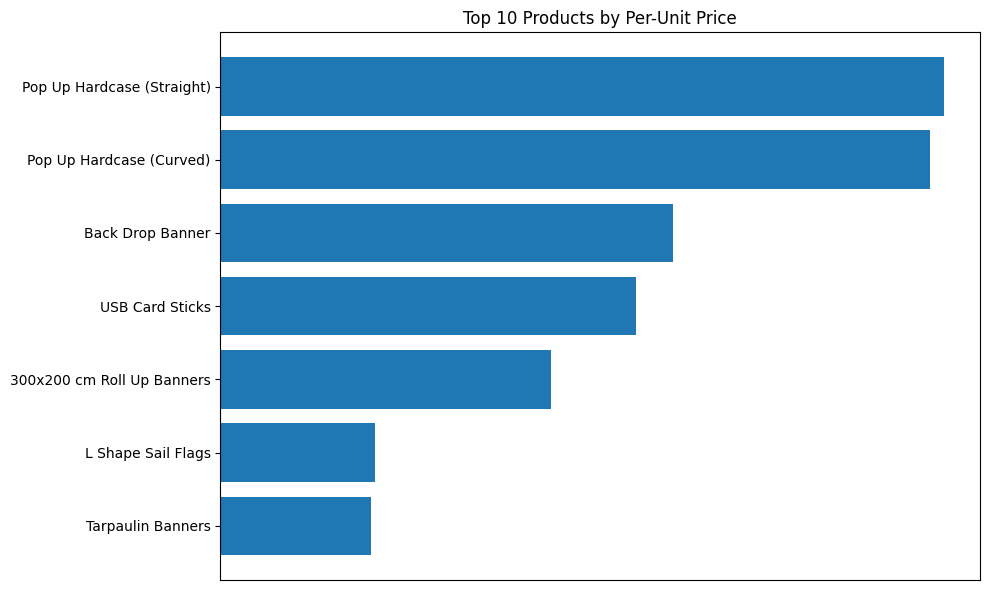

In [98]:
# Plot Top 10 by Per-Unit Price
top10 = grouped.nlargest(10, 'Per_unit_price')[['Product', 'Per_unit_price']]
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top10['Product'], top10['Per_unit_price'])
ax.invert_yaxis()


ax.set_xticks([])
ax.set_xlabel('')
ax.xaxis.set_ticklabels([])

ax.set_title('Top 10 Products by Per-Unit Price')
plt.tight_layout()
plt.show()

